# Trench normal analysis
In this notebook, I analyze the earthquakes in each trench normal profile

- make sure that trench perpendicular distance is included in your outputs
- plot trench perpendicular profile and events 
- add an inset map
- do this for all profiles
- then analyze

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ternary # ternary plot has a bug
import plotly.express as px
import h5py
import matplotlib as mpl

# for beachball - there are some error with using obspy
from pyrocko.plot import beachball
from pyrocko import moment_tensor as mtm

import cartopy 
import cartopy.mpl.geoaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from pathlib import Path

from dateutil import parser
from datetime import datetime, timezone

%matplotlib inline

In [2]:
def compute_measurables(eq_to_proc, max_pos, ds):
    
    eq_to_proc = eq_to_proc.drop_duplicates(subset = ['EVENT_ID'], keep = 'first')  # col 6 is the EQ event
    print(eq_to_proc.shape)

    eq_to_proc = eq_to_proc.reset_index(drop=True)
    proc_df = eq_to_proc.sort_values(by = 'ALONG', ascending = True)
    along_pos = pd.unique(proc_df['ALONG'])
    along_tot_energy = np.zeros(along_pos.shape[0])
    along_max_mag = np.zeros(along_pos.shape[0])
    along_num_ev = np.zeros(along_pos.shape[0])

    grp = proc_df.groupby('ALONG')
    event_cnt = 0
    idx = 0
    for pos in along_pos:
        to_proc = grp.get_group(pos)
        along_num_ev[idx] = to_proc.shape[0]

        for i, row in to_proc.iterrows():

            exp = np.asarray(row['EX'])
            mo = np.asarray(row['MO'])
            mw = np.asarray(row['MW'])

            energy = mo*np.power(10., exp)

            #if mw > along_max_mag[idx]: # get the max magnitude
            #    along_max_mag[idx] = mw
            if energy > along_max_mag[idx]: # get the max magnitude
                along_max_mag[idx] = energy

            along_tot_energy[idx] += energy

            event_cnt += 1

        idx += 1
    
   
    
    along_tot_energy = np.array(along_tot_energy)
    # convert to Mw
    #along_tot_energy = (np.log10(along_tot_energy) - 9.05)/1.5
    
    along_max_mag = np.array(along_max_mag)
    along_max_mag = (np.log10(along_max_mag) - 9.05)/1.5
    
    along_pos = np.array(along_pos)

    #along_pos = max_pos - along_pos # need to reverse shit - 07/08/2020 - needed to remove this soon
    
    pos_all = np.arange(0, max_pos + ds, ds)
    fin_tot_en = np.zeros(pos_all.shape)
    fin_max_mag = np.zeros(pos_all.shape)
    fin_num_ev = np.zeros(pos_all.shape)

    idx = (along_pos)//ds
    
    # assign to 
    fin_tot_en[idx] = along_tot_energy
    fin_max_mag[idx] = along_max_mag
    fin_num_ev[idx] = along_num_ev
    
    return pos_all, fin_tot_en, fin_max_mag, fin_num_ev

In [5]:
fname1 = '/Users/jgra0019/Documents/codes/other_areas/out/sum_out/along_trench_seis/100km_step_isc_unc_thresh/sum_isc_mthrust_collated.csv'
fname2 = '/Users/jgra0019/Documents/codes/other_areas/out/sum_out/along_trench_seis/100km_step_isc_20km_thresh/sum_isc_mthrust_collated_20km_thresh.csv'

fname3 = '/Users/jgra0019/Documents/codes/other_areas/out/sum_out/along_trench_seis/100km_step_merged_nets/sum_merged_collated_nets.csv'
fname4 = '/Users/jgra0019/Documents/codes/focal_meca/output/07_2020_processing/100km_step/collated.csv'

slab_fname = '/Users/jgra0019/Documents/phd_data/sum_slab/sum_slab2_dep_no_nan.csv'
trench_xy = '/Users/jgra0019/Documents/phd_data/trench/sumatra_trench_st_anda.txt'
depth_fname = '/Users/jgra0019/Documents/codes/slab-geometry/outdir/sum/tr_norm_depth/50km_step/depth_at_prof_50.csv'
thk_fname = '/Users/jgra0019/Documents/codes/slab-geometry/outdir/sum/tr_norm_thk/50km_step/stat_at_prof_50.csv'
strk_fname = '/Users/jgra0019/Documents/codes/slab-geometry/outdir/sum/tr_norm_str/100km_step/str_at_trench_100.csv'
trench_xy_plt = '/Users/jgra0019/Documents/phd_data/trench/sumatra_full.txt'

trench_plt = pd.read_csv(trench_xy_plt, sep=',', header = None)
trench_plt.columns = ['LON', 'LAT']

depth_df = pd.read_csv(depth_fname)
thk_df = pd.read_csv(thk_fname)

#thk_df['Along'] = (thk_df['Along'] - thk_df['Along'].max()).abs()

depth_df = depth_df.sort_values('ALONG')
#depth_df['Along'] = (depth_df['Along'] - depth_df['Along'].max()).abs()
depth_df['LENGTH'] = np.abs(depth_df['LENGTH'])

depth_df['AREA'] = depth_df['LENGTH']*thk_df['Mean']

eq_df_isc1 = pd.read_csv(fname1, header = 'infer')
eq_df_isc2 = pd.read_csv(fname2, header = 'infer')
eq_df_gcmt1 = pd.read_csv(fname3, header = 'infer')
eq_df_gcmt2 = pd.read_csv(fname4, header = 'infer')

slab_df = pd.read_csv(slab_fname, header = 'infer')
slab_df = slab_df.sample(frac=0.3, replace=False, random_state=1)

trench_df = pd.read_csv(trench_xy, sep=',', header = None)
trench_df.columns = ['LON', 'LAT']

# drop duplicates soon
eq_df_isc1 = eq_df_isc1.drop_duplicates(subset='EVENT_ID', keep = 'last') # keep last (probably updates)
eq_df_isc2 = eq_df_isc2.drop_duplicates(subset='EVENT_ID', keep = 'last') # keep last (probably updates)
eq_df_gcmt1 = eq_df_gcmt1.drop_duplicates(subset='EVENT_ID', keep = 'last') # keep last (probably updates)
eq_df_gcmt2 = eq_df_gcmt2.drop_duplicates(subset='EVENT_ID', keep = 'last') # keep last (probably updates)
eq_df_gcmt1 = eq_df_gcmt1[eq_df_gcmt1['CLASS'] == 'MTHRUST']
eq_df_gcmt2 = eq_df_gcmt2[eq_df_gcmt2['CLASS'] == 'MTHRUST']

max_pos = eq_df_isc1['ALONG'].max()
print(max_pos)
#subset = eq_df_isc1[eq_df_isc1['ALONG'] == 4100]

strk_df = pd.read_csv(strk_fname)

6100


In [4]:
#eq_df_gcmt1['CLASS'].unique()

In [6]:
# compute the gradients of the slab area
step = 50
depth_arr = np.array(depth_df['AREA'])

pos_first_der = np.array(depth_df['ALONG'])[:-1] 
pos_sec_der = np.array(depth_df['ALONG'])[1:-1] 

first_der = -(depth_arr[1:] - depth_arr[:-1])/(2*step)
sec_der = -(depth_arr[2:] - 2*depth_arr[1:-1] + depth_arr[:-2])/(step**2)

# Read model results for 20 km plate

In [7]:
# thickness = 20 km
deflection_file = "/Users/jgra0019/Documents/codes/plate-bending-diff-bndry/\
new_results/sumatra_load/el_area_sc_sstvty_thk/el_3d_deflect_thk_1.hdf5"
deflection = h5py.File(deflection_file, "r")
deflect_3d = deflection['deflection']
deflect_3d = np.array(deflect_3d)
edge_load = np.array(deflection['edge_load'])[40:-40]
edge_moment = np.array(deflection['edge_moment'])[40:-40]

delta = deflection.attrs['delta']
x = np.arange(0, delta*(deflect_3d.shape[0]), delta)/1e3
y = np.arange(0, delta*(deflect_3d.shape[1]-80), delta)/1e3
deflect_3d = deflect_3d[:, 40:-40]
def_3d_20km = deflect_3d

deflection_file = "/Users/jgra0019/Documents/codes/plate-bending-diff-bndry/\
new_results/sumatra_load/el_area_sc_sstvty_thk/el_2d_deflect_thk_1.hdf5"
deflection = h5py.File(deflection_file, "r")
#print(list(deflection.keys()))
deflect_2d = deflection['deflection']
deflect_2d = np.array(deflect_2d)
delta = deflection.attrs['delta']
x = np.arange(0, delta*(deflect_2d.shape[0]), delta)/1e3
y = np.arange(0, delta*(deflect_2d.shape[1]-80), delta)/1e3
deflect_2d = deflect_2d[:, 40:-40]
def_2d_20km = deflect_2d

# thickness = 20 km but removed fluctuations with period 100 km or less
deflection_file = "/Users/jgra0019/Documents/codes/plate-bending-diff-bndry/\
new_results/sumatra_load/el_area_sc_sstvty_filt_2/el_3d_deflect_filt_0.hdf5"
deflection = h5py.File(deflection_file, "r")
deflect_3d = deflection['deflection']
deflect_3d = np.array(deflect_3d)[:, 40:-40]
area_3d_200km = deflect_3d

deflection_file = "/Users/jgra0019/Documents/codes/plate-bending-diff-bndry/\
new_results/sumatra_load/el_area_sc_sstvty_filt_2/el_2d_deflect_filt_0.hdf5"
deflection = h5py.File(deflection_file, "r")
deflect_2d = deflection['deflection']
deflect_2d = np.array(deflect_2d)[:, 40:-40]
area_2d_200km = deflect_2d


# 20 km 
delta_rho = 2300
g = 9.82

el_3d = -delta_rho*g*def_3d_20km
el_2d = -delta_rho*g*def_2d_20km
el_diff_20km = el_3d - el_2d

el_3d = -delta_rho*g*area_3d_200km
el_2d = -delta_rho*g*area_2d_200km
area_diff_200km = el_3d - el_2d

sig_comp = el_diff_20km[-1]/1e6
sig_comp_200km = area_diff_200km[-1]/1e6

# Reference places 
Different reference places for different regions

In [8]:
ref_file = '/Users/jgra0019/Documents/codes/maps-gmt/misc_data/process_output/reference_pts_collated.csv'
ref_pts = pd.read_csv(ref_file, header = 'infer')#[[6, 15]]
ref_pts.drop_duplicates(subset = ['EVENT_ID'], keep = 'last', inplace = True)
ref_pts['LABEL'] = ['X', 'Sumatra', 'Y', 'Z', 'Java', 'Z']
#ref_pts['ALONG'] = -ref_pts['ALONG'] + 6075
ref_pts = ref_pts.sort_values(by=['ALONG'])
ref_pts = ref_pts.iloc[[2, 4]]
ref_pts

,LON,LAT,DEPTH,DATE,TIME,EVENT_ID,DEPFIX,DEPQUAL,EX,MO,...,N_AZM,CLASS,P(km),Q(km),R(deg),S(deg),ALONG,PROF,TTSUM,LABEL
6,95.365978,5.524967,10,2020-02-02,00:58:50.00,4,False,L3,1,1,...,24,Aceh,286.841199551,-14.007262,95.305615,5.635688,2400,L0-048,15.11233,Java
2,105.684046,-5.593960,10,2020-02-02,00:58:50.00,5,True,L4,1,1,...,24,South,Sumatra,298.409623,-16.180288,105.551831,4300,L0-086,15.11233,Sumatra


## Assign earthquake type using methodology from Frohlich 1992
- Incorporated slab dip in classification - 26/08/2020

# Incorporate the strike and dip when assigning the earthquake type
- Modified the angles to use in classification

# Analysis strategy
- try these thresholds in the sea-ward direction: 50 km, 100 km
- then try different depth thresholds: 150 km and for each plot
    - seismicity as a function of time 
    - cumulative moment
    - maximum moment
    

### I. Threshold sea-ward direction

In [9]:
thresh_seaward = -20 # original is 100

subset_eq_isc1 = eq_df_isc1[eq_df_isc1['P(km)'] > thresh_seaward]
subset_eq_isc2 = eq_df_isc2[eq_df_isc2['P(km)'] > thresh_seaward]

subset_eq_gcmt1 = eq_df_gcmt1[eq_df_gcmt1['P(km)'] > thresh_seaward]
subset_eq_gcmt2 = eq_df_gcmt2[eq_df_gcmt2['P(km)'] > thresh_seaward]

No handles with labels found to put in legend.


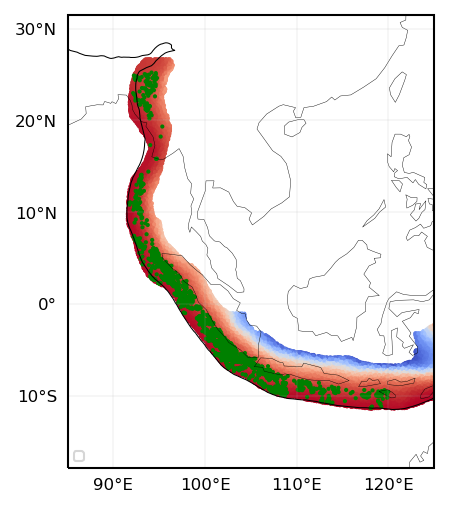

In [10]:
fig, ax = plt.subplots(dpi = 150)
m = plt.axes(projection = cartopy.crs.PlateCarree())


m.set_extent([85, 125, -17, 30])
m.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
gl = m.gridlines(linewidth = 0.1, draw_labels = True)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180 + 10, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90 + 10, 10))
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 8}
gl.xlabel_style = {'size': 8}


m.scatter(slab_df['LON'],slab_df['LAT'], s = 0.5, c = slab_df['DEPTH'], transform=cartopy.crs.PlateCarree(), cmap = plt.cm.coolwarm) #yc, xc -- lists or numpy arrays

#plot events
m.scatter(subset_eq_isc1['LON'], subset_eq_isc1['LAT'], s = 4, c = 'g', edgecolor = 'none', transform=cartopy.crs.PlateCarree())
m.plot(trench_plt['LON'], trench_plt['LAT'], '-', c = 'k', linewidth = 0.5)
m.legend(loc = 'lower left', fontsize = 6)

# 1, 2, 3 - r, theta, phi 
# M11, M22, M33, M12, M13, M23 - Mrr, Mtt, Mpp, Mrt, Mpr, Mtp


### Seismicity as a function of time

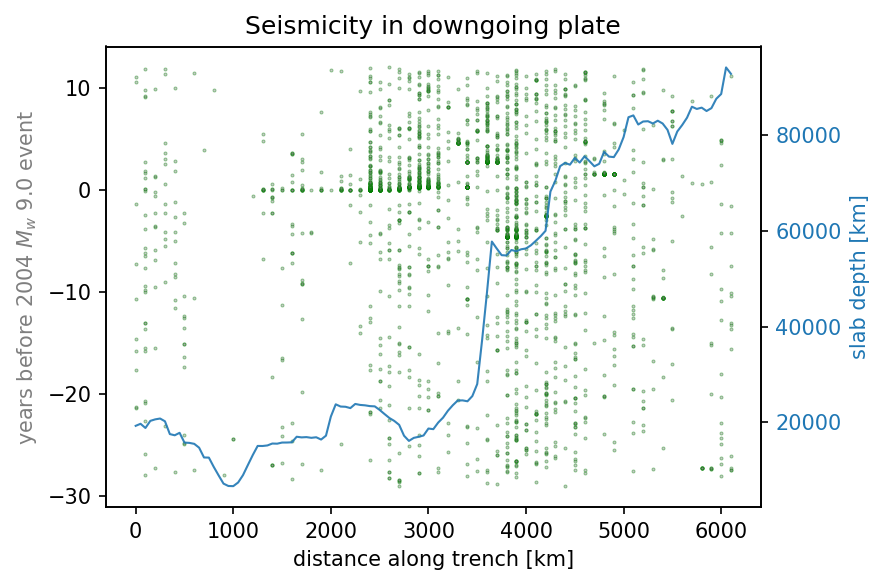

In [11]:
fig, ax1 = plt.subplots(dpi = 150)

plt.title('Seismicity in downgoing plate')
color = 'tab:gray'
ax1.set_xlabel('distance along trench [km]')
ax1.set_ylabel(r'years before 2004 $M_w\ 9.0$ event', color=color)  # we already handled the x-label with ax1
#ax1.scatter(subset_eq_isc1[subset_eq_isc1['CLASS'] == 'DGOING']['ALONG'], subset_eq_isc1[subset_eq_isc1['CLASS'] == 'DGOING']['TTSUM'], s = subset_eq_isc1[subset_eq_isc1['CLASS'] == 'DGOING']['MW']**1.2, linewidth = 0.5, edgecolors = 'r', alpha = 0.4, c = color)
ax1.scatter(subset_eq_isc1['ALONG'], subset_eq_isc1['TTSUM'], s = 2, linewidth = 0.5, edgecolors = 'g', alpha = 0.4, c = color)
#ax1.scatter(subset_eq_isc1[subset_eq_isc1['CLASS'] == 'UPPER']['ALONG'], subset_eq_isc1[subset_eq_isc1['CLASS'] == 'UPPER']['TTSUM'], s = subset_eq_isc1[subset_eq_isc1['CLASS'] == 'UPPER']['MW']**1.2, linewidth = 0.5, edgecolors = '', alpha = 0.4, c = color)
# ax1.plot([along_2004 - 1300, along_2004], [0, 0], 'o-', linewidth = 2, color = 'gold')
# ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('slab depth [km]', color=color)
ax2.plot(depth_df['ALONG'], depth_df['AREA'], '-', color=color, alpha = 0.9, linewidth = 1)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([-30, 20])
#ax2.set_xlim([-200 - 3550, 6300 - 3550])

#ax2.text(-2750, 510, r'2004 $M_w$ 9.0 event', color = 'gold', weight='bold')
#ax2.vlines(3550, 200, 900)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig(output_dir + '/'+prefix+'_time_vs_trench.png', dpi = 300)

In [12]:
# get earthquake type and depth threshold

#mthrust_eq = subset_eq[subset_eq['TTSUM'] < 0]
mthrust_eq_isc1 = subset_eq_isc1
mthrust_eq_isc2 = subset_eq_isc2

mthrust_eq_gcmt1 = subset_eq_gcmt1
mthrust_eq_gcmt2 = subset_eq_gcmt2

print(mthrust_eq_isc1.shape)
print(mthrust_eq_isc2.shape)
print(mthrust_eq_gcmt1.shape)
print(mthrust_eq_gcmt2.shape)

(2395, 43)
(3234, 43)
(843, 43)
(901, 43)


In [13]:
# add year column

# ISC method 1
ev_year = [] 
for idx, ev in mthrust_eq_isc1.iterrows():
    
    date = parser.parse(ev['DATE'])
    ev_year.append(date.year)
    
mthrust_eq_isc1['EV_YEAR'] = ev_year

# ISC method 2
ev_year = [] 
for idx, ev in mthrust_eq_isc2.iterrows():
    
    date = parser.parse(ev['DATE'])
    ev_year.append(date.year)
    
mthrust_eq_isc2['EV_YEAR'] = ev_year

# GCMT-ISC method 1
ev_year = [] 
for idx, ev in mthrust_eq_gcmt1.iterrows():
    
    date = parser.parse(ev['DATE'])
    ev_year.append(date.year)
    
mthrust_eq_gcmt1['EV_YEAR'] = ev_year

# GCMT-ISC method 2
ev_year = [] 
for idx, ev in mthrust_eq_gcmt2.iterrows():
    
    date = parser.parse(ev['DATE'])
    ev_year.append(date.year)
    
mthrust_eq_gcmt2['EV_YEAR'] = ev_year

print(mthrust_eq_isc1['EV_YEAR'].min())
print(mthrust_eq_isc1['EV_YEAR'].max())

1976
2016


In [14]:
# generate the years to use in here

min_yr = 1976
max_yr = 2016 
d_year = 8
#yr_to_use = np.arange(min_yr + d_year, max_yr + d_year, d_year)
yr_to_use = np.array([2005, 2017])
label_dict = {2005: r"< 2005", 2017: r"< 2017"}
yr_to_use

array([2005, 2017])

# Megathrust analysis
With the ISC dataset, we can only analyze the occurence/count of events in the megathrust. We will analyze the cumulative distribution of megathrust events along the trench and look at different time periods. 

In [15]:
# solve for the things to analyze - MEGATHRUST
step = 100

# ISC method 1
num_ev_dict_isc1 = {}

for yr in yr_to_use:
    to_use_df = mthrust_eq_isc1[mthrust_eq_isc1['EV_YEAR'] < yr]
    pos_mth_isc1, _, _, num_ev_mth = compute_measurables(to_use_df, max_pos, step)
    num_ev_dict_isc1[yr] = num_ev_mth
    
    
# ISC method 2
num_ev_dict_isc2 = {}
for yr in yr_to_use:
    to_use_df = mthrust_eq_isc2[mthrust_eq_isc2['EV_YEAR'] < yr]
    pos_mth_isc2, _, _, num_ev_mth = compute_measurables(to_use_df, max_pos, step)
    num_ev_dict_isc2[yr] = num_ev_mth
    
# GCMT method 1
num_ev_dict_gcmt1 = {}
tot_en_dict_gcmt1 = {}

for yr in yr_to_use:
    to_use_df = mthrust_eq_gcmt1[mthrust_eq_gcmt1['EV_YEAR'] < yr]
    pos_mth_gcmt1, tot_en_mth, _, num_ev_mth = compute_measurables(to_use_df, max_pos, step)
    num_ev_dict_gcmt1[yr] = num_ev_mth
    tot_en_dict_gcmt1[yr] = tot_en_mth
    
# GCMT method 2
num_ev_dict_gcmt2 = {}
tot_en_dict_gcmt2 = {}

for yr in yr_to_use:
    to_use_df = mthrust_eq_gcmt2[mthrust_eq_gcmt2['EV_YEAR'] < yr]
    pos_mth_gcmt2, tot_en_mth, _, num_ev_mth = compute_measurables(to_use_df, max_pos, step)
    num_ev_dict_gcmt2[yr] = num_ev_mth
    tot_en_dict_gcmt2[yr] = tot_en_mth
    
# cumulative events
#pos_mth_isc1, tot_en_isc1, max_mag_isc1, num_ev_mth_isc1 = compute_measurables(mthrust_eq_isc1, max_pos, step)


(1120, 44)
(2395, 44)


/Users/jgra0019/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10


(1510, 44)
(3234, 44)
(286, 44)
(843, 44)
(312, 44)
(901, 44)


248.85
85.05
8.067984307454839e+22


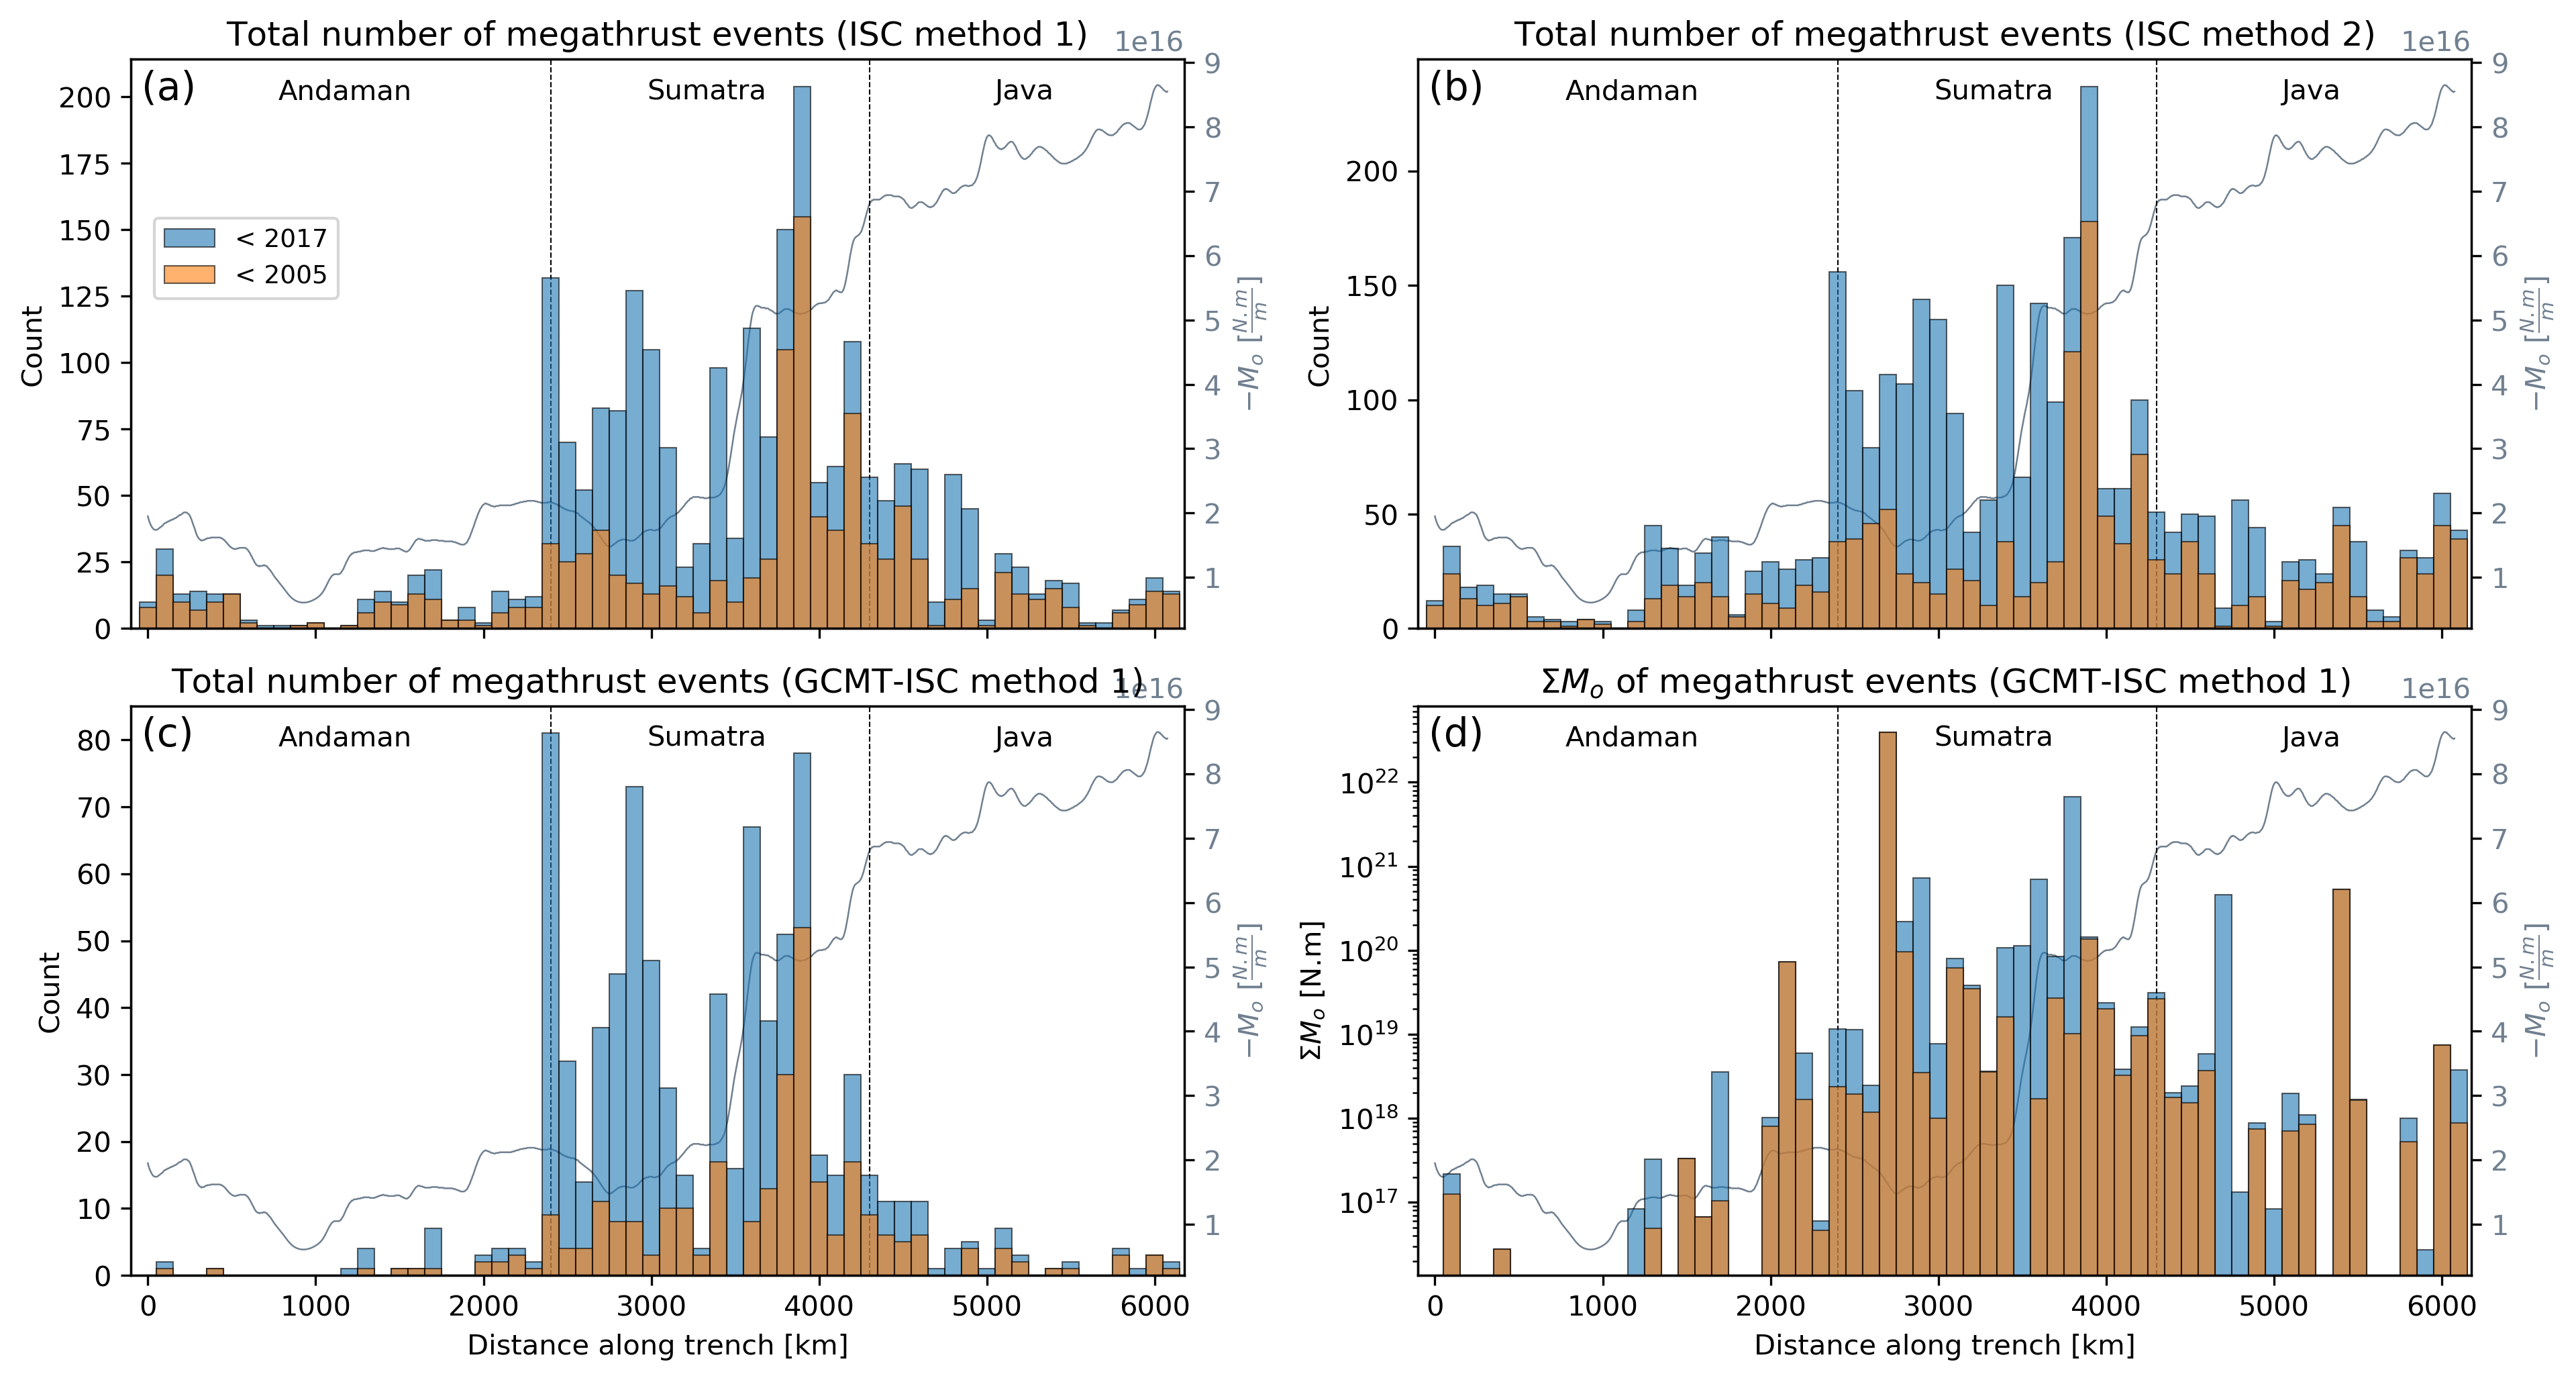

In [23]:
# plot the results of analysis
plot_moment = True

if plot_moment:
    wspace = 0.1
else:
    wspace = 0.15

width = 100
xmin = y.min() - 100
xmax = y.max() + 100

fig = plt.figure(constrained_layout = False, figsize= (15, 8), dpi = 300) #w x h

spec = fig.add_gridspec(ncols = 11, nrows = 10, hspace = 1.5, wspace = wspace)

ax_00 = fig.add_subplot(spec[0:5, 0:5])
ax_01 = fig.add_subplot(spec[0:5, 6:11])
ax_10 = fig.add_subplot(spec[5:10, 0:5])
ax_11 = fig.add_subplot(spec[5:10, 6:11])

ax_00.set_title('Total number of megathrust events (ISC method 1)',y = 0.995)
ax_00.set_ylabel(r'Count') 
ax_00.set_xticklabels([])

# plot of the total moment release in shallow depth seismicity
for key in sorted(num_ev_dict_isc1.keys(), reverse=True):
    ax_00.bar(pos_mth_isc1, num_ev_dict_isc1[key], linewidth = 0.5, edgecolor = 'k', width = width, alpha = 0.6, label = label_dict[key], zorder = 2)
ax_00.set_zorder(2)
ax_00.patch.set_visible(False)
ax_00.legend(loc = 'upper right')

# setting limits
ax_dummy = ax_00.twiny()
ymin = plt.gca().get_ylim()[0]
ymax = plt.gca().get_ylim()[1]
ax_dummy.axis('off')
ax_00.set_xlim([xmin, xmax]) # already set in previous code blocks
ax_00.set_ylim([ymin, ymax])

########################
# PLOT 0,1
########################

ax_01.set_title('Total number of megathrust events (ISC method 2)',y = 0.995)
ax_01.set_ylabel(r'Count') 
ax_01.set_xticklabels([])

for key in sorted(num_ev_dict_isc2.keys(), reverse=True):
    ax_01.bar(pos_mth_isc2, num_ev_dict_isc2[key], linewidth = 0.5, edgecolor = 'k', width = width, alpha = 0.6, label = label_dict[key], zorder = 2)
ax_01.set_zorder(2)
ax_01.patch.set_visible(False)
#ax_01.legend(loc = 'upper left')

ax_dummy = ax_01.twiny()
ymin = plt.gca().get_ylim()[0]
ymax = plt.gca().get_ylim()[1]
print(ymax)
ax_dummy.axis('off')

ax_01.set_xlim([xmin, xmax]) # already set in previous code blocks
ax_01.set_ylim([ymin, ymax])

########################
# PLOT 1,0
########################

ax_10.set_title('Total number of megathrust events (GCMT-ISC method 1)',y = 0.995)
ax_10.set_ylabel(r'Count') 
ax_10.set_xlabel('Distance along trench [km]')

for key in sorted(num_ev_dict_gcmt1.keys(), reverse=True):
    ax_10.bar(pos_mth_gcmt1, num_ev_dict_gcmt1[key], linewidth = 0.5, edgecolor = 'k', width = width, alpha = 0.6, label = label_dict[key], zorder = 2)

ax_10.set_zorder(2)
ax_10.patch.set_visible(False)
#ax_10.legend(loc = 'upper left')

ax_dummy = ax_10.twiny()
ymin = plt.gca().get_ylim()[0]
ymax = plt.gca().get_ylim()[1]
print(ymax)
ax_dummy.axis('off')

ax_10.set_xlim([xmin, xmax]) # already set in previous code blocks
ax_10.set_ylim([ymin, ymax])

########################
# PLOT 1,1
########################


ax_11.set_title(r'$\Sigma M_{o}$ of megathrust events (GCMT-ISC method 1)',y = 0.995)
ax_11.set_ylabel(r'$\Sigma M_{o}$ [N.m]') 
ax_11.set_xlabel('Distance along trench [km]')

for key in sorted(num_ev_dict_gcmt1.keys(), reverse=True):
    ax_11.bar(pos_mth_gcmt1, tot_en_dict_gcmt1[key], linewidth = 0.5, edgecolor = 'k', width = width, alpha = 0.6, label = label_dict[key], zorder = 2)

ax_11.set_yscale('log')
ax_11.set_zorder(2)
ax_11.patch.set_visible(False)
#ax_11.legend(loc = 'upper left')

ax_dummy = ax_11.twiny()
ymin = plt.gca().get_ylim()[0]
ymax = plt.gca().get_ylim()[1]
print(ymax)
ax_dummy.axis('off')

ax_11.set_xlim([xmin, xmax]) # already set in previous code blocks
ax_11.set_ylim([ymin, ymax])


###### PLOT ELEMENTS COMMON TO ALL ######
ax_list = [ax_00, ax_01, ax_10, ax_11]
text_to_put = ['(a)', '(b)', '(c)', '(d)']
cnt = 0 
for ax in ax_list:
    ####### TEXT #######
    ymin = ax.get_ylim()[0]
    ymax = ax.get_ylim()[1]
    ax.vlines(ref_pts.iloc[0]['ALONG'], ymin, ymax, linestyles = '--', linewidth =0.5, color = 'k') # Andaman
    ax.vlines(ref_pts.iloc[1]['ALONG'], ymin, ymax, linestyles = '--', linewidth = 0.5, color = 'k') # Nicobar

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'slategrey'
    
    if plot_moment:
        # bending moment
        ax2.plot(y, -edge_moment, '-', color=color, linewidth = 0.6, zorder = 1)
        ax2.set_ylabel(r'$-M_o$ [$\frac{N.m}{m}$]', color = color)
        ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    
    else:
        # stress difference
        ax2.plot(y, sig_comp_200km, '-', color=color, linewidth = 0.6, zorder = 1)
        ax2.set_ylabel(r'$\Delta\sigma_T$ [MPa]', color = color)
        ax2.set_yticks([-0.5, 0, 0.5, 1.0])
        ax2.set_yticklabels([-0.50,0, 0.5, 1.0])
        
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.spines['right'].set_color(color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_zorder(1)
    
    ax.text(0.14, 0.93, 'Andaman', transform = ax.transAxes, fontsize = 10)
    ax.text(0.49, 0.93, 'Sumatra', transform = ax.transAxes, fontsize = 10)
    ax.text(0.82, 0.93, 'Java', transform = ax.transAxes, fontsize = 10)

    ax.text(0.01, 0.93, text_to_put[cnt], transform = ax.transAxes, fontsize = 14)
    
    if cnt == 0:
        ax.legend(loc = 'center left', fontsize = 9, bbox_to_anchor = (0.01, 0.65))
    
    cnt += 1

